## 1. Импорт зависимостей

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
import os
import time
import torch
import random
import datetime
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score
    )
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import (
    TensorDataset, random_split, DataLoader,
    RandomSampler, SequentialSampler
    )
from transformers import(
    BertForSequenceClassification, AdamW,
    BertTokenizer, AutoTokenizer,
    get_linear_schedule_with_warmup
    )

Проверим доступность GPU

In [116]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 2. Загрузка данных

Данные, в отличие от других файлов используются в виде тренировочной и тестовой выборки, чтобы не хранить одновременно лишние данные в памяти.

Данные были разделены на train и test с помощью sklearn train_test_split с random_state=42.

In [117]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("drive/MyDrive/train_data.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 298,053



,review,review_snippet,category
43120,В интернете вообще очень сложно встретить поло...,"Кстати, ещё есть некоторые пары дистанционно, ...",Образовательная деятельность + НИР
212182,Здравствуйте. Хотела бы тоже написать негативн...,И даже на лекциях/семинарах правильное ударени...,Образовательная деятельность + НИР
48132,"Я доволен знаниями, полученными за 4 года обуч...","Я доволен знаниями, полученными за 4 года обуч...",Образовательная деятельность + НИР
125961,В списках ФЭФ очень много олимпиадников с ориг...,В списках ФЭФ очень много олимпиадников с ориг...,Финансово-экономическая деятельность
22095,Всем кто ещё не определился и рассматривает да...,"Однако, при всех прочих равных довелось мне ощ...",Лояльность к ВУЗу
49150,"Чистота и новизна аудитории поражает, но огорч...","Чистота и новизна аудитории поражает, но огорч...",Лояльность к ВУЗу
283853,Начиталась тут всего удивительного и хочу расс...,"Оснащение не по первому слову техники, но для ...",Образовательная деятельность + НИР
111312,Московский гуманитарный университет- \nдействи...,"Стоит отметить, что вуз помогает вам с",Лояльность к ВУЗу
292462,"Отучился первый год, все нравится! Учиться инт...","Отучился первый год, все нравится",Лояльность к ВУЗу
222502,Приехала поступать на заочную форму обучения. ...,"И вправду, списки в последний раз обновлялись ...",Финансово-экономическая деятельность


In [118]:
text_column = 'review_snippet'
label_column = 'category'

In [119]:
df[label_column].unique()

array(['Лояльность к ВУЗу', 'Образовательная деятельность + НИР',
       'Финансово-экономическая деятельность',
       'Административная деятельность', 'Внеучебная деятельность',
       'Инфраструктура'], dtype=object)

In [120]:
encoder = LabelEncoder()
encoder.fit(df[label_column])
df[label_column] = encoder.transform(df[label_column])

In [121]:
df.head()

,review,review_snippet,category
0,На сайте МГУПП выложили еще три образовательны...,"МГУПП, ""Я тебя замучаю любовью могучею, Жаркою...",3
1,Всем привет! Отзыв о РУДН может быть либо обье...,Он читает на бакалавриате курс «спортивная жур...,4
2,"Отличный институт,старшая ходила в ,, Ступеньк...",ны приемлемы,5
3,Ректор РНИМУ (он биохимик) первым делом разогн...,Ректор РНИМУ (он биохимик) первым делом разогн...,0
4,"Если есть возможность, то стоит, вуз хорошо ко...","Если есть возможность, то стоит, вуз хорошо ко...",1


In [122]:
# Get the lists of sentences and their labels.
texts = df[text_column].astype(str).values
labels = df[label_column].values.astype(int)

In [123]:
texts[:3], labels[:3]

(array(['МГУПП, "Я тебя замучаю любовью могучею, Жаркою, опасною и разнообразною!" (С)',
        'Он читает на бакалавриате курс «спортивная журналистика» (еще он читает какие-то предметы в магистратуре, но точно не могу сказать, потому что с ребятами с магистратуры мы практически не пересекаемся)',
        'ны приемлемы'], dtype=object),
 array([3, 4, 5]))

In [124]:
classes_amount = len(df[label_column].unique())
classes_amount

6

# 3. Токенизация & Форматирование Input

В данной секции преобразуем данные к формату, с которым работает BERT.

## 3.1. BERT Tokenizer

В ходе работы будем использовать предобученную модель архтектуры BERT на русском языке: cointegrated/rubert-tiny2

In [125]:
model_name = 'cointegrated/rubert-tiny2'
batch_size = 32
random_state = 42

In [126]:
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name)

Loading cointegrated/rubert-tiny2 tokenizer...


Применим токенайзер к одному из наших текстов и посмотрим, что получится.


In [127]:
# Print the original sentence.
print('Original: ', texts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(texts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.encode(texts[0]))

Original:  МГУПП, "Я тебя замучаю любовью могучею, Жаркою, опасною и разнообразною!" (С)
Tokenized:  ['МГУ', '##ПП', ',', '"', 'Я', 'тебя', 'заму', '##чаю', 'любовью', 'могу', '##че', '##ю', ',', 'Жар', '##кою', ',', 'опасно', '##ю', 'и', 'разнообраз', '##ною', '!', '"', '(', 'С', ')']
Token IDs:  [2, 21737, 36341, 16, 6, 311, 29852, 51459, 42177, 37044, 11677, 2847, 920, 16, 60919, 5636, 16, 41223, 920, 320, 30679, 5559, 5, 6, 12, 297, 13, 3]


## 3.2. Токенизация данных

Перед тем, как закодировать текст, найдем максимальную длину текстов.


В ячейке ниже происходит проход по датасету для определения максимальной длины.

In [128]:
max_length = 0
text_lens = []

for text in texts:
  input_ids = tokenizer.encode(text, add_special_tokens=True)
  current_len = len(input_ids)
  text_lens.append(current_len)

text_lens = np.array(text_lens)
max_length = text_lens.max()
print('Max sentence length: ', max_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (6112 > 2048). Running this sequence through the model will result in indexing errors


Max sentence length:  6112


In [129]:
# 1. Mean
mean = text_lens.mean()

# 2. Variance
variance = text_lens.var()

# 3. Standard deviation
std = text_lens.std()

# 4. Quartiles
Q1 = np.percentile(text_lens, 25)
Q2 = np.percentile(text_lens, 50)
Q3 = np.percentile(text_lens, 75)

# Print results
print("Mean:", mean)
print("Median:", Q2)
print("Variance:", variance)
print("Standard deviation:", std)
print(f"Q1 = {Q1}, Q3 = {Q3}")


Mean: 25.048702747497927
Median: 20.0
Variance: 4761.615810043571
Standard deviation: 69.00446224733275
Q1 = 13.0, Q3 = 30.0


За длину возьмем 3 квартиль

In [130]:
max_length = int(Q3)

Формируем токенизированные множества.

In [131]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def preparing_text_and_labels(texts, labels, max_length, truncation=False):
    input_ids = []
    attention_masks = []

    for text in texts:

        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = max_length,
                            padding='max_length',
                            return_attention_mask = True,
                            return_tensors = 'pt',
                            truncation=truncation
                    )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels


In [132]:
input_ids, attention_masks, labels = preparing_text_and_labels(texts, labels, max_length=max_length, truncation=True)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  МГУПП, "Я тебя замучаю любовью могучею, Жаркою, опасною и разнообразною!" (С)
Token IDs: tensor([    2, 21737, 36341,    16,     6,   311, 29852, 51459, 42177, 37044,
        11677,  2847,   920,    16, 60919,  5636,    16, 41223,   920,   320,
        30679,  5559,     5,     6,    12,   297,    13,     3,     0,     0])


## 3.3. Training & Validation Split


Разделим данные на train и val в пропорции  90% к 10%.

In [133]:
train_part = 0.9

In [134]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(train_part * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

268,247 training samples
29,806 validation samples


Также создадим итератор с использование класса  DataLoader из библиотеки torch.

In [135]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size
        )

Теперь, когда данные отформатированы, можем обучить модель.

## 4.1. BertForSequenceClassification

In [136]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = classes_amount, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Using GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

Ради интереса выведем на печать параметры для нескольких слоев:


1. The embedding layer.
2. Первый из 12 ти трансформеров.
3. The output layer.




In [137]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 57 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (83828, 312)
bert.embeddings.position_embeddings.weight               (2048, 312)
bert.embeddings.token_type_embeddings.weight                (2, 312)
bert.embeddings.LayerNorm.weight                              (312,)
bert.embeddings.LayerNorm.bias                                (312,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (312, 312)
bert.encoder.layer.0.attention.self.query.bias                (312,)
bert.encoder.layer.0.attention.self.key.weight            (312, 312)
bert.encoder.layer.0.attention.self.key.bias                  (312,)
bert.encoder.layer.0.attention.self.value.weight          (312, 312)
bert.encoder.layer.0.attention.self.value.bias                (312,)
bert.encoder.layer.0.attention.output.dense.weight        (312, 312)
bert.encoder.layer.0.attention.output.dense.bias              (3

## 4.2. Optimizer & Learning Rate Scheduler

Определим optimizer и sheduler.

Наиболее популярные конфигурации параметров:
- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

Мы выберем:
* Batch size: 32 (при инициализации DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

Параметр эпсилон `eps = 1e-8` - это "очень маленькое число", которое позволяет избежать деления на 0

In [138]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [139]:
epochs = 4

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Ниже приведена петля обучения (training loop). На каждом проходе по данным мы проходим по всему обучающему и валидационную датасетам.


**Training:**
- Распаковать обучающие данные и лейблы
- Загрузить данные на GPU для ускорения
- Занулить градиенты с предыдущего шаге
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Backward pass (backpropagation - посчитать градиенты по всем параметрам с помощью обратного распространения ошибки)
- Обновить параметры с помощью optimizer.step()
- Посчитать статистики, чтобы следить за обучением

**Evalution:**
- Распаковать валидационные данные и лейблы
- Загрузить данные на GPU для ускорения
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Посчитать loss и статистики на валидационных данных, чтобы следить за обучением

##

Вспомогательная функция для вычисления F1.

In [140]:
# Function to calculate the f1 of our predictions vs labels
def flat_f1(preds, labels, average):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average=average)

Вспомогательная функция для отслеживания затраченного времени.


In [141]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Все готово к обучению! Приступим!

In [142]:
def fine_tune_model(train_dataloader, validation_dataloader,  average, random_state=random_state):

    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            res = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # Validation
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_f1 = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():

                res = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                loss = res['loss']
                logits = res['logits']

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_f1 += flat_f1(logits, label_ids, average)


        # Report the final accuracy for this validation run.
        avg_val_f1 = total_eval_f1 / len(validation_dataloader)
        print("  F1: {0:.2f}".format(avg_val_f1))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. F1.': avg_val_f1,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")

    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [143]:
training_stats = fine_tune_model(train_dataloader, validation_dataloader, average='macro')


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  8,383.    Elapsed: 0:00:01.
  Batch    80  of  8,383.    Elapsed: 0:00:02.
  Batch   120  of  8,383.    Elapsed: 0:00:03.
  Batch   160  of  8,383.    Elapsed: 0:00:04.
  Batch   200  of  8,383.    Elapsed: 0:00:05.
  Batch   240  of  8,383.    Elapsed: 0:00:05.
  Batch   280  of  8,383.    Elapsed: 0:00:06.
  Batch   320  of  8,383.    Elapsed: 0:00:07.
  Batch   360  of  8,383.    Elapsed: 0:00:08.
  Batch   400  of  8,383.    Elapsed: 0:00:09.
  Batch   440  of  8,383.    Elapsed: 0:00:10.
  Batch   480  of  8,383.    Elapsed: 0:00:10.
  Batch   520  of  8,383.    Elapsed: 0:00:11.
  Batch   560  of  8,383.    Elapsed: 0:00:12.
  Batch   600  of  8,383.    Elapsed: 0:00:13.
  Batch   640  of  8,383.    Elapsed: 0:00:14.
  Batch   680  of  8,383.    Elapsed: 0:00:15.
  Batch   720  of  8,383.    Elapsed: 0:00:16.
  Batch   760  of  8,383.    Elapsed: 0:00:17.
  Batch   800  of  8,383.    Elapsed: 0:00:17.
  Batch   840  of

Посмотрим на саммари обучающего процесса!

In [144]:
# Display floats with two decimal places.
pd.set_option("display.max_columns", 100)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. F1.,Training Time,Validation Time
epoch,,,,,
1,0.556814,0.419127,0.754539,0:02:59,0:00:05
2,0.396833,0.392185,0.771007,0:02:58,0:00:06
3,0.347324,0.390519,0.776771,0:02:58,0:00:05
4,0.318567,0.391613,0.775713,0:02:58,0:00:05


Обратите внимание, что loss на обучении непрерывно падает, а на валидации начинает возрастать. Это говорит о том, что модель переобучается.

Loss на валидации - более надежный способ, чем F1, так как F1 не зависит от типа ошибки и уверенности классификатора в ответе.


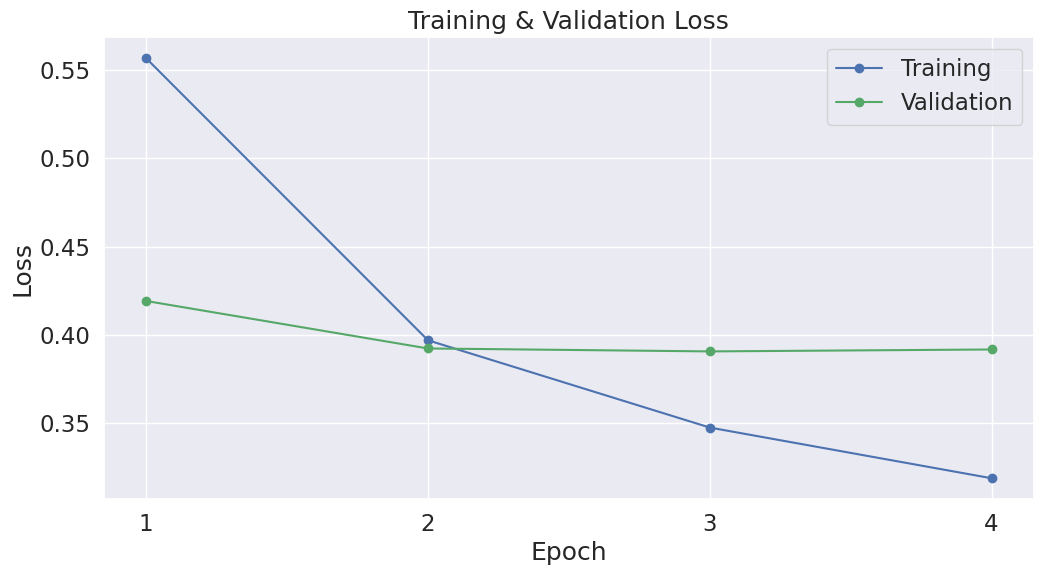

In [145]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Качество на отложенной выборке. Для оценки качества зафайнтьюненой модели оценим качество на тесте с использованием F1_score.

### 5.1. Подготовка данных



Применим к тестовым данным те же шаги предобработки данных, которые мы применяли для обучающей и валидационной выборкок.

In [146]:
df = pd.read_csv('drive/MyDrive/test_data.csv')

In [147]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

Number of test sentences: 52,598



In [148]:
df.groupby(label_column).count()

,review,review_snippet
category,,
Административная деятельность,3753,3753
Внеучебная деятельность,2388,2388
Инфраструктура,6878,6878
Лояльность к ВУЗу,7539,7539
Образовательная деятельность + НИР,29279,29279
Финансово-экономическая деятельность,2761,2761


In [149]:
df[label_column]

,category
0,Инфраструктура
1,Финансово-экономическая деятельность
2,Лояльность к ВУЗу
3,Образовательная деятельность + НИР
4,Инфраструктура
...,...
52593,Инфраструктура
52594,Образовательная деятельность + НИР
52595,Образовательная деятельность + НИР
52596,Инфраструктура


In [150]:
# Create sentence and label lists
texts = df[text_column].astype(str).values
labels = encoder.fit_transform(df[label_column])

In [151]:
texts[:2]

array(['Огромная территория,со своим спорткомплексом, что безумно удобно,прекрасные парки,прям как в санатории, а учиться как здорово в такой красоте!))',
       'Студенту некуда деться (разве что перевестись в другой ВУЗ), и он решает остаться здесь, платит постоянно растущие суммы за семестр (но это мелочи'],
      dtype=object)

In [152]:
labels

array([2, 5, 3, ..., 4, 2, 3])

In [153]:
# Tokenize all of the texts and map the tokens to thier word IDs.
input_ids, attention_masks, labels = preparing_text_and_labels(texts, labels, max_length, truncation=True) #Truncation for evoiding long cases


In [154]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Оценка на тесте



После того, как мы подготовили тестовые данные, сгенерируем предсказания с использованием дообученной модели.

In [155]:
# Prediction on test set
def get_predictions(model, prediction_dataloader):
  print('Predicting labels for {:,} test texts...'.format(len(input_ids)))
  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  print()
  print('DONE.')
  return predictions, true_labels

In [156]:
predictions, true_labels = get_predictions(model, prediction_dataloader)

Predicting labels for 52,598 test texts...

DONE.


В качестве метрики возьмем F1.

Данную метрику используют в силу несбалансированности классов в данных:


In [158]:
f1_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating F1 Score for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  f1 = f1_score(true_labels[i], pred_labels_i, average='macro')
  f1_set.append(f1)

Calculating F1 Score for each batch...


Финальный скор считается по всему датасету, дополнительно посмотрим на скоры на отдельных батчах.


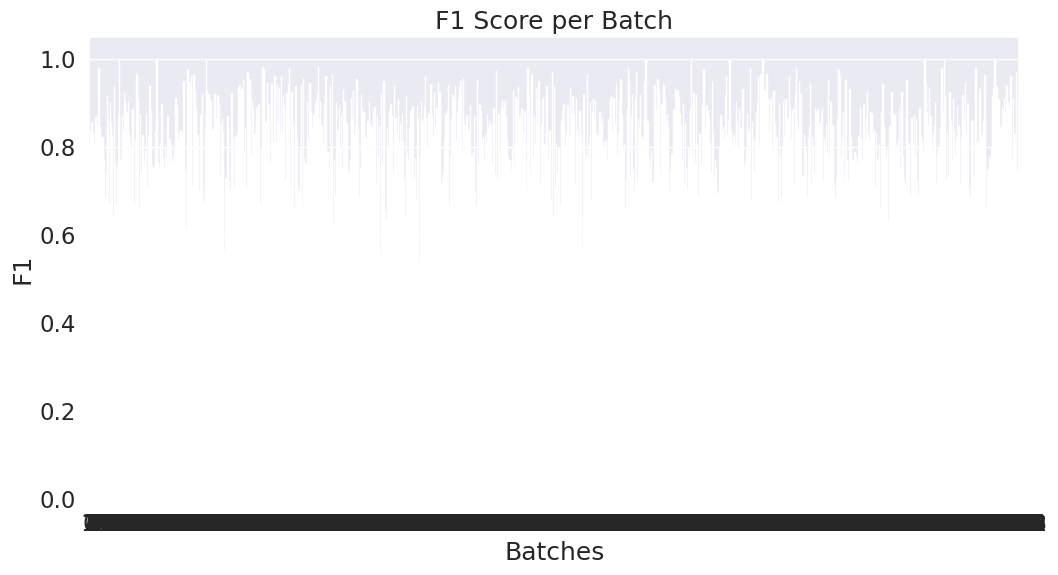

In [159]:
# Create a barplot showing the F1 score for each batch of test samples.
ax = sns.barplot(x=list(range(len(f1_set))), y=f1_set, errorbar=None)

plt.title('F1 Score per Batch')
plt.ylabel('F1')
plt.xlabel('Batches')

plt.show()

Объединим результаты и получим общий скор.

In [1]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions, average='macro')
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions, average='macro')
recall = recall_score(flat_true_labels, flat_predictions, average='macro')


print('Total Accuracy: %.3f' % accuracy)
print('Total Precision: %.3f' % precision)
print('Total Recall: %.3f' % recall)
print('Total F1: %.3f' % f1)

NameError: name 'np' is not defined


**Успех!** Спустя небольшое количество времени мы получили хорошую модель с качеством выше чем у моделей, обученных с нуля.



# Заключение

Используя предобученную сеть cointegrated/rubert-tiny2 с помощью простого файн тюнинга удается добиться лучшего качества среди всех моделей. А также модель довольно быстро обучается, что позволит в дальнейшем только улучшать её.

##  Сохранение модели

Код ниже позволяет сохранить дообученную модель и соотвествующий ей токенайзер на диск.

Так как код выполнялся на GPU Google Colab.

In [2]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


NameError: name 'os' is not defined

Посмотрим размеры файлов.

In [3]:
!ls -l --block-size=K ./model_save/

ls: cannot access './model_save/': No such file or directory


In [4]:
!ls -l --block-size=M ./model_save/model.safetensors

ls: cannot access './model_save/model.safetensors': No such file or directory


Файл весит всего 112 мб

Код ниже позволяет сохранить модель из колаба на Google Disk.

In [5]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/myfile_andreykasha"

Код ниже позволяет загрузить сохраненную модель.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
